In [2]:
#Importando las librerías transversales (Data exploring)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Necesarias para el proceso de modelaje se utilizaran tres metodos para la detención de si fue un ataque o no basado en la literatura
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import *
from sklearn.linear_model import *
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.preprocessing import *
from sklearn.impute import *
from sklearn.pipeline import *
# Necesarias para el proceso de selección de variables
from sklearn.cluster import *
from sklearn.feature_selection import *
# Necesarios para procesos de mineria de datos
from fim import eclat

In [3]:
# Declaramos explicitamente los encabezados con sus respectivos tipos
header = ['timestamp', 'uid', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p', 'proto', 'service', 'duration', 'orig_bytes', 'resp_bytes', 'conn_state', 'local_orig', 'local_resp', 'missed_bytes', 'history', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'tunnel_parents', 'label', 'detailed-label']
dtypes = {'timestamp': 'float', 'uid': 'string', 'id.orig_h': 'string', 'id.orig_p': 'Int64', 'id.resp_h': 'string', 'id.resp_p': 'Int64', 'proto': 'string', 'service': 'string', 'duration': 'float', 'orig_bytes': 'Int64', 'resp_bytes': 'Int64', 'conn_state': 'string', 'local_orig': 'boolean', 'local_resp': 'boolean', 'missed_bytes': 'Int64', 'history': 'string', 'orig_pkts': 'Int64', 'orig_ip_bytes': 'Int64', 'resp_pkts': 'Int64', 'resp_ip_bytes': 'Int64', 'tunnel_parents': 'string', 'label': 'string', 'detailed-label': 'string'}
# Lectura correspondiente del dataset
df = pd.read_csv('../data/conn.log.labeled', delimiter='\t', header=None, skiprows=8,na_values=['(empty)', '-'], keep_default_na=False, names=header, dtype=dtypes)
# Imprimimos las primeras filas del dataframe
display(df.head())

,timestamp,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,label,detailed-label
0,1.545404e+09,CrDn63WjJEmrWGjqf,192.168.1.195,41040,185.244.25.235,80,tcp,<NA>,3.139211,0,...,<NA>,0,S,3,180,0,0,- Benign -,,
1,1.545404e+09,CY9lJW3gh1Eje4usP6,192.168.1.195,41040,185.244.25.235,80,tcp,<NA>,NaN,<NA>,...,<NA>,0,S,1,60,0,0,- Benign -,,
2,1.545404e+09,CcFXLynukEDnUlvgl,192.168.1.195,41040,185.244.25.235,80,tcp,<NA>,NaN,<NA>,...,<NA>,0,S,1,60,0,0,- Benign -,,
3,1.545404e+09,CDrkrSobGYxHhYfth,192.168.1.195,41040,185.244.25.235,80,tcp,http,1.477656,149,...,<NA>,2896,ShADadttcfF,94,5525,96,139044,- Benign -,,
4,1.545404e+09,CTWZQf2oJSvq6zmPAc,192.168.1.195,41042,185.244.25.235,80,tcp,<NA>,3.147116,0,...,<NA>,0,S,3,180,0,0,- Benign -,,


In [4]:
# Observamos la forma original de nuestro dataset
df.shape

(23145, 23)

In [5]:
# Solucionamos el problema de tabulación del dataset que agrupa 3 columnas en una.
df[['tunnel_parents', 'label', 'detailed-label']] = df['tunnel_parents'].str.split(expand=True)

In [6]:
# Información de variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23145 entries, 0 to 23144
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   timestamp       23145 non-null  float64
 1   uid             23145 non-null  string 
 2   id.orig_h       23145 non-null  string 
 3   id.orig_p       23145 non-null  Int64  
 4   id.resp_h       23145 non-null  string 
 5   id.resp_p       23145 non-null  Int64  
 6   proto           23145 non-null  string 
 7   service         1847 non-null   string 
 8   duration        5321 non-null   float64
 9   orig_bytes      5321 non-null   Int64  
 10  resp_bytes      5321 non-null   Int64  
 11  conn_state      23145 non-null  string 
 12  local_orig      0 non-null      boolean
 13  local_resp      0 non-null      boolean
 14  missed_bytes    23145 non-null  Int64  
 15  history         23145 non-null  string 
 16  orig_pkts       23145 non-null  Int64  
 17  orig_ip_bytes   23145 non-null 

### 1- NFS Limite definido
![NFS](../assets/NFS.png)

#### 1.1 Descubriendo patrones de las transacciones (Conexiones en la red) con la tecnica FIM

In [7]:
transactions = []
for index, row in df.iterrows():
    # Crear una lista de valores no nulos para cada fila del dataframe
    transaction = [str(val) for val in row.values if pd.notnull(val)]
    transactions.append(transaction)

# Aplicar FIM utilizando el algoritmo ECLAT
# 'm' significa encontrar patrones maximales es decir, patrones que no están contenidos en otros patrones más grandes.
# '2' soporte mínimo que se busca para los patrones que aparezcan en más de dos transacciones
patterns = eclat(transactions, target='m', supp=2)

# Imprimir los patrones frecuentes y su soporte
for pattern, support in patterns:
    print(pattern, support)


('8', '192.168.1.195', '-', '0') 463
('48', '147.231.100.5', '192.168.1.195', '-', '0', '1', 'Benign', 'udp', '123', '76', 'SF', 'Dd') 702
('589', 'ShAdDaf', '192.168.1.195', '-', '0', 'tcp', 'Malicious', '185.244.25.235', '6667', 'C&C', 'irc', 'S3', '6', '62', '269') 518
('D', '76', '192.168.1.195', '-', '0', 'S0', 'udp', '1', 'Benign', '123') 823
('563', 'ShAdDaf', '192.168.1.195', '-', '0', 'tcp', 'Malicious', '185.244.25.235', '6667', 'C&C', 'irc', 'S3', '6', '75', '243') 702
('7', '243', '192.168.1.195', '-', '0', 'tcp', 'Malicious', '185.244.25.235', '6667', 'C&C', 'irc', 'S3', '75') 463
('7', '6', 'ShAdDaf', '192.168.1.195', '-', '0', 'tcp', 'Malicious', '185.244.25.235', '6667', 'C&C', 'irc', 'S3') 537
('60', '1', 'S', 'C&C', '192.168.1.195', '-', 'tcp', '185.244.25.235', '0', 'S0', 'Malicious', '6667') 2412
('180', 'C&C', '192.168.1.195', '-', '0', 'tcp', '185.244.25.235', 'S0', 'S', '3', 'Malicious', '6667') 2650
('65279', 'C', '192.168.1.195', '-', '0', 'tcp', 'Malicious', '

#### 1.2 Visualizar los soportes con respecto de los patrones encontrados

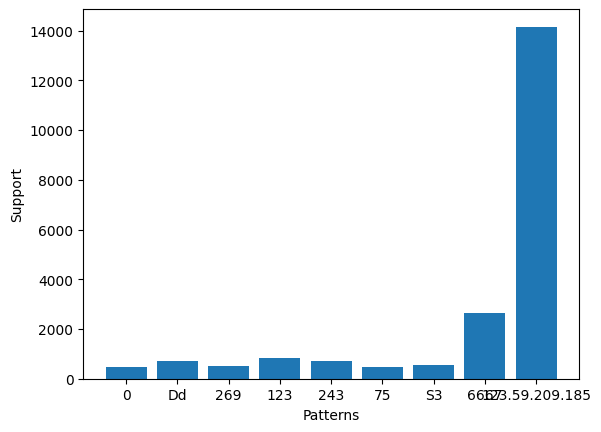

In [8]:
# Convertir los datos en un array de tipo object
data_array = np.array(patterns, dtype=object)
strings = []
for tupla in data_array[:,0]:
    # Convertir el ultimo caracter de la tupla a un string para mejorar la visualización utilizando join()
    string = ''.join(map(str, tupla[-1]))
    strings.append(string)
# Graficar los datos como una gráfica de barras
plt.bar(strings, data_array[:,1])
plt.xlabel('Patterns')
plt.ylabel('Support')
plt.show()

#### 1.3 Obtener el valor de frecuencia del patrón más dominante

In [9]:
# Calcular la frecuencia dominante
total = sum([support for _, support in patterns])
dominant_frequency = max([support / total for _, support in patterns])
# Imprimir la frecuencia
print("Frecuencia dominate:", dominant_frequency)

Frecuencia dominate: 0.6043365060395237


#### 1.4 Encontrar la lista de variables valiosas que esten por encima del umbral predifinido

In [10]:
# Seleccionar características con frecuencia por encima del umbral
selected_features = []
for pattern, support in patterns:
    # Limite definido por conocimiento de experto
    if support / total >= 0.5:
        selected_features.extend(pattern)
print('Patron Sleccionado', selected_features)
keys = ['id.orig_p', 'history', 'id.orig_h','label', 'orig_pkts', 'proto','label', 'id.resp_p','detailed-label', 'conn_state', 'id.resp_h']

Patron Sleccionado ['65279', 'C', '192.168.1.195', '-', '0', 'tcp', 'Malicious', '80', 'DDoS', 'OTH', '123.59.209.185']


In [11]:
# Visualizar Reduced features data con limite definido
display(df[keys].head())

,id.orig_p,history,id.orig_h,label,orig_pkts,proto,label,id.resp_p,detailed-label,conn_state,id.resp_h
0,41040,S,192.168.1.195,Benign,3,tcp,Benign,80,-,S0,185.244.25.235
1,41040,S,192.168.1.195,Benign,1,tcp,Benign,80,-,S0,185.244.25.235
2,41040,S,192.168.1.195,Benign,1,tcp,Benign,80,-,S0,185.244.25.235
3,41040,ShADadttcfF,192.168.1.195,Benign,94,tcp,Benign,80,-,SF,185.244.25.235
4,41042,S,192.168.1.195,Benign,3,tcp,Benign,80,-,S0,185.244.25.235


### 2- Feature Selection with k-means
![NFS](../assets/WFS.png)

### 2- Sin Limite definido

#### 2.1 Extraemos la muestra del conjunto de datos iterando a través de cada valor de característica y extrayendo las frecuencias de patrones más dominantes.

In [12]:
# Por temas de visualizacion posteriores 
table_data = []
for feature_name in df.columns:
    max_count = 0
    feature_v = 0
    feature_cnts = df[feature_name].value_counts().to_dict()
    # Contar la cantidad de valores únicos en la columna
    for uniq_v in feature_cnts.keys():
        v_count = feature_cnts.get(uniq_v)
        if v_count > max_count:
            max_count = v_count
            feature_v = uniq_v
    table_data.append([feature_name, feature_v,max_count, (max_count/len(df))*100])


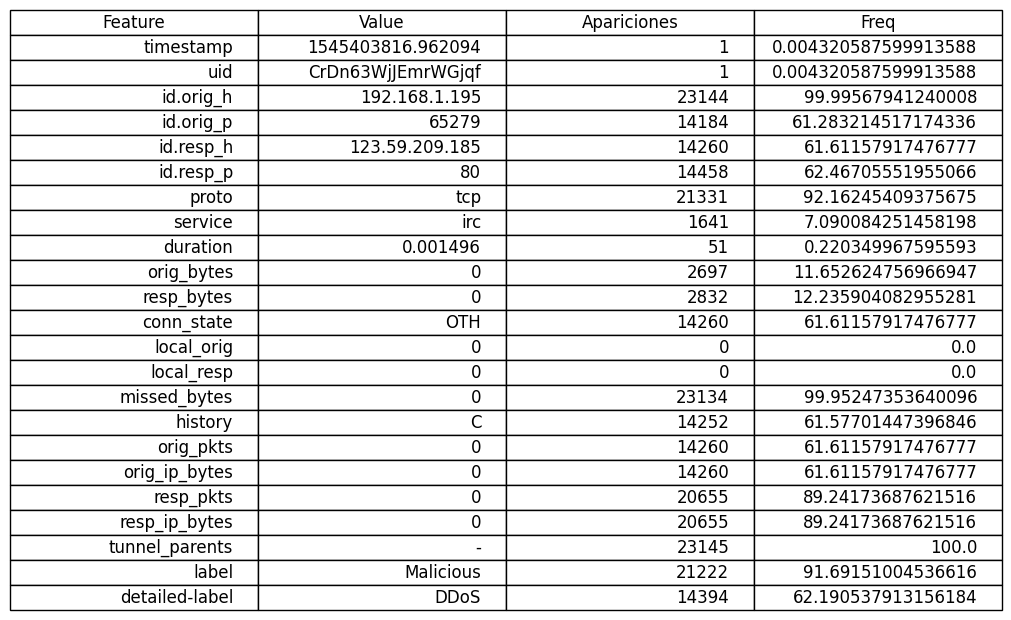

In [13]:
fig, ax = plt.subplots()
table = ax.table(cellText=table_data, colLabels=['Feature', 'Value','Apariciones', 'Freq'], loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(2, 1.5)
ax.axis('off')
plt.show()

#### 2.2 Filtramos features que se encuentren por debajo del umbral definido

In [14]:
# Convertir la lista en un array de NumPy
feature_values = np.array(table_data)
# Filtrar lista
feature_values = feature_values[np.where(feature_values[:, 3].astype(float)  > 50)]
# Nuestro componente de feature sample extractor nos elimina variables que no se encuentre por tanto:
featureValuesDf = df.drop(["local_orig", "local_resp", 'uid', 'timestamp', 'service', 'duration', 'orig_bytes', 'resp_bytes'], axis=1)
# Nota quedamos con las siguientes 15 features
display(featureValuesDf.head())

,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,label,detailed-label
0,192.168.1.195,41040,185.244.25.235,80,tcp,S0,0,S,3,180,0,0,-,Benign,-
1,192.168.1.195,41040,185.244.25.235,80,tcp,S0,0,S,1,60,0,0,-,Benign,-
2,192.168.1.195,41040,185.244.25.235,80,tcp,S0,0,S,1,60,0,0,-,Benign,-
3,192.168.1.195,41040,185.244.25.235,80,tcp,SF,2896,ShADadttcfF,94,5525,96,139044,-,Benign,-
4,192.168.1.195,41042,185.244.25.235,80,tcp,S0,0,S,3,180,0,0,-,Benign,-


#### 2.3 Luego partiendo de las dos target clases (Malicioso, Normal) sacamos el puntaje de impuridad de Gini.

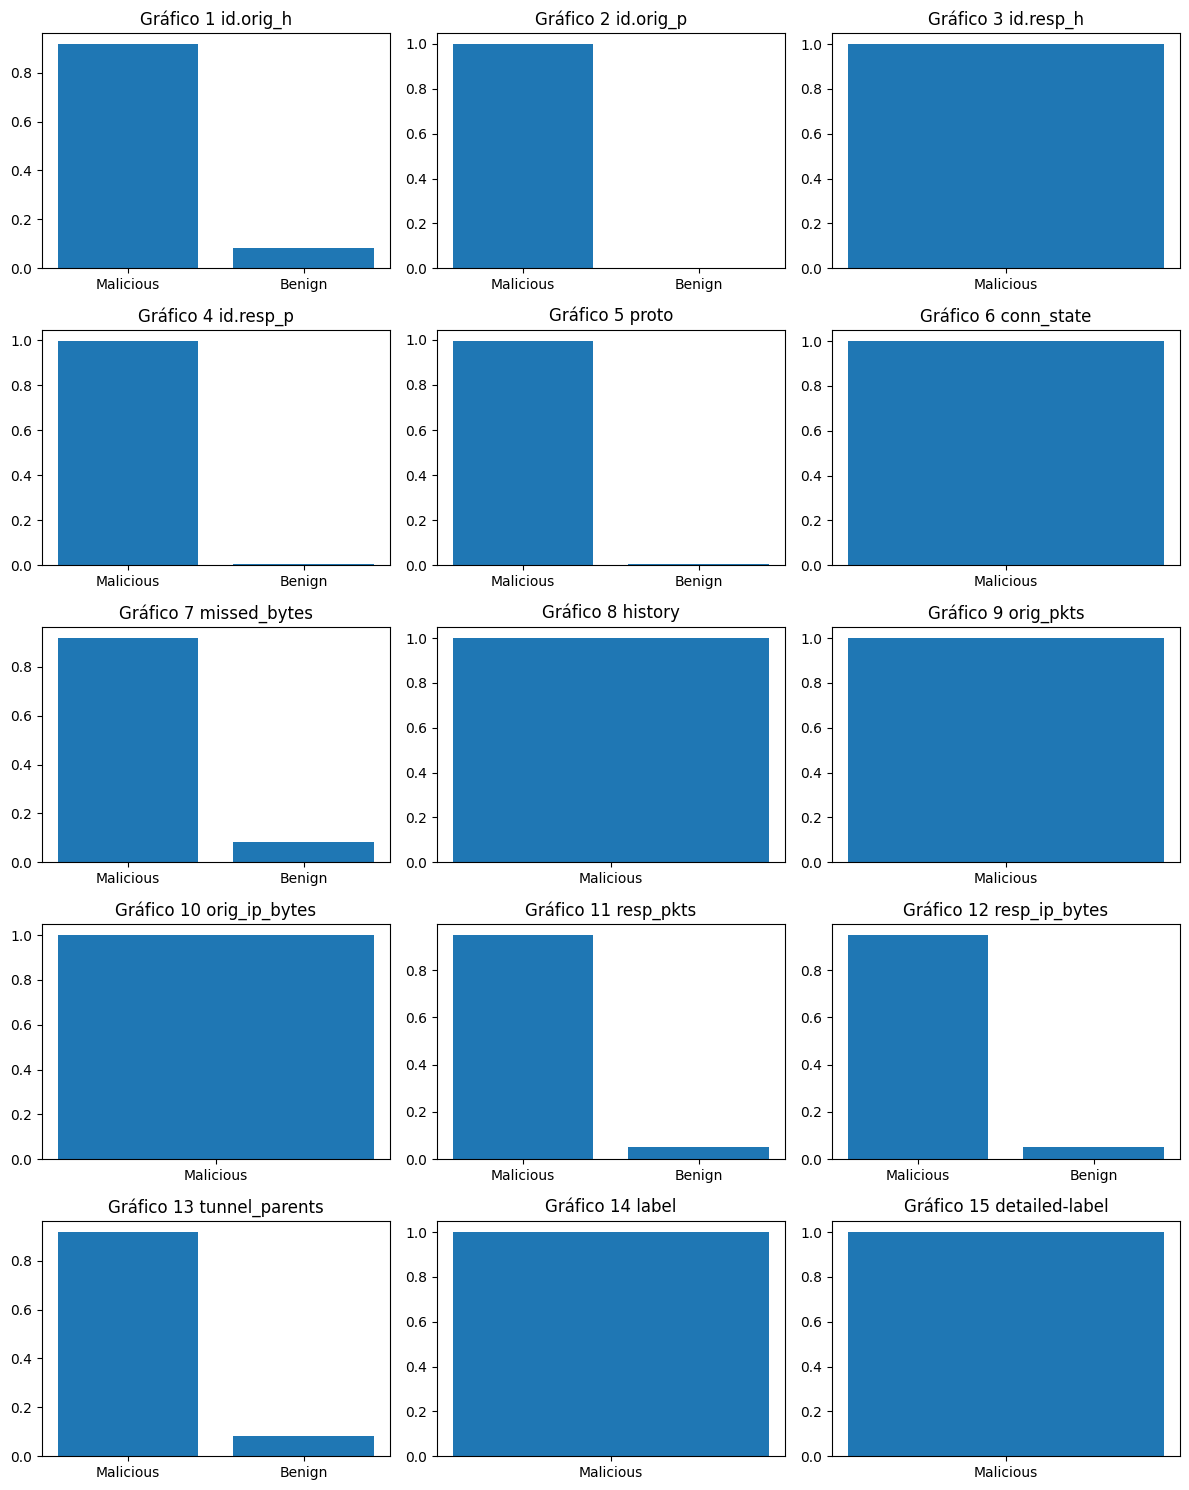

[['id.orig_h', '192.168.1.195', 0.15229752579889078], ['id.orig_p', '65279', 0.000845665810622398], ['id.resp_h', '123.59.209.185', 0.0], ['id.resp_p', '80', 0.008951137673624876], ['proto', 'tcp', 0.010353231442398414], ['conn_state', 'OTH', 0.0], ['missed_bytes', '0', 0.15163614372678902], ['history', 'C', 0.0], ['orig_pkts', '0', 0.0], ['orig_ip_bytes', '0', 0.0], ['resp_pkts', '0', 0.09858679446387875], ['resp_ip_bytes', '0', 0.09858679446387875], ['tunnel_parents', '-', 0.1523635980274265], ['label', 'Malicious', 0.0], ['detailed-label', 'DDoS', 0.0]]


In [15]:
# Arreglo de salidas
features_with_impure_score = []
# Crear subplots
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(12, 15))

for index, feature_name in enumerate(featureValuesDf.columns):
    max_count = feature_values[index][2]
    feature_v = feature_values[index][1]
    feature = feature_values[index][1]
    # Transformar el tipo de dato
    if featureValuesDf[feature_name].dtype == 'Int64':
       feature = np.int64(feature_values[index][1])
    # Crear un subconjunto del dataframe con la columna y el valor más frecuente
    datas = featureValuesDf[featureValuesDf[feature_name] == feature]
    # Calcular el índice Gini del subconjunto partiento de la columna de etiqueta que contiene las dos target clases
    p = datas['label'].value_counts(normalize=True)
    # Creamos un nuevo DataFrame con los conteos
    counts_df = pd.DataFrame({'Clase': p.index, 'Count': p.values})
    # Agregamos al grafico de barras solo si pertenece al conjunto de features values
    (axs.flatten()[index]).bar(counts_df['Clase'], counts_df['Count'])
    (axs.flatten()[index]).set_title(f'Gráfico {index +1} {feature_name}')
    # Calcular puntaje de impureza de Gini
    gini = 1 - (p ** 2).sum()
    # Agregar a salida de componente
    features_with_impure_score.append([feature_name, feature_v, gini])

# Ajustar diseño y mostrar grafico
plt.tight_layout()
plt.show()
# Retornar la lista de patrones y sus puntajes
print(features_with_impure_score)

#### 2.4 Visualizar puntaje de impureza para cada feature

<Figure size 640x480 with 0 Axes>

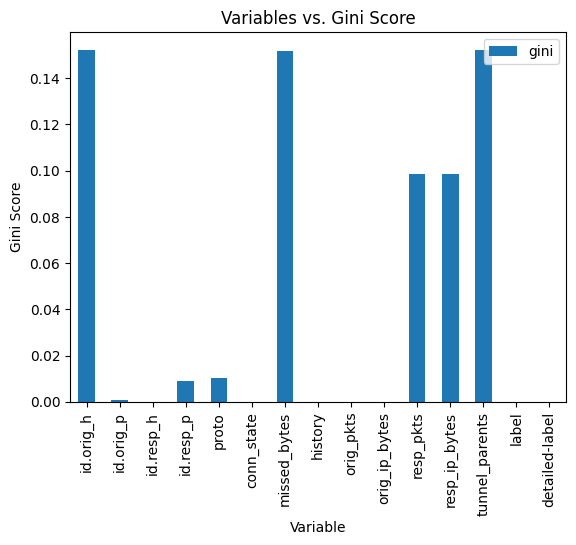

In [16]:
# Convertimos a dataframe de pandas
dfGini = pd.DataFrame(features_with_impure_score, columns=['column', 'value', 'gini'])
# Plotear
plt.figure()
dfGini.plot(x='column', y='gini', kind='bar')
plt.xlabel('Variable')
plt.ylabel('Gini Score')
plt.title('Variables vs. Gini Score')
plt.show()
# La puntuación GI de una característica más dominante se considera pura si su valor 
# de patrón más dominante solo está presente en una clase objetivo (ya sea Normal o Malicioso).

#### 2.5 Algoritmo de K-Means para automatizar la selección de variables

In [17]:
# Creamos una lista con los scores de Gini para cada feature
gini_scores = np.array(features_with_impure_score)[:,2]
# Conviertimos la lista en un array de NumPy para usar con el algoritmo de clustering
X = gini_scores.reshape(-1, 1)

# Aplicamos el algoritmo de K-Means clustering con K=2
kmeans = KMeans(n_clusters=2, random_state=42, n_init='auto').fit(X)

# Obtenemos los grupos a los que pertenece cada feature
groups = kmeans.labels_

# Usamos los grupos obtenidos para seleccionar los features más influyentes
influential_features = [featureValuesDf.columns[i] for i in range(len(groups)) if groups[i] == 1]

# Usamos los grupos obtenidos para seleccionar los features menos influyentes
less_influential_features = [featureValuesDf.columns[i] for i in range(len(groups)) if groups[i] == 0]

# Obtenemos el reduce features data removiendo las columnas de etiquetas y detalles dado que son para usos de conocimiento 
# del negocio mas no para el modelo
reduce_features_data = influential_features[:-2]

# Imprimimos los resultados
print('Features más influyentes:', reduce_features_data)
print('Features menos influyentes:', less_influential_features)

Features más influyentes: ['id.orig_p', 'id.resp_h', 'id.resp_p', 'proto', 'conn_state', 'history', 'orig_pkts', 'orig_ip_bytes']
Features menos influyentes: ['id.orig_h', 'missed_bytes', 'resp_pkts', 'resp_ip_bytes', 'tunnel_parents']


## 3- Entrenamiento de algortmos de detencion
![image.png](../assets/MODEL.png)

#### 3.1- Preparar datos de entrenamiento y prueba

In [18]:
# Preprocesar los datos tipo string dado que los modelos solo trabajan con valores numeros
le = LabelEncoder()
stringColumns = ['uid', 'id.orig_h', 'id.resp_h', 'proto', 'service', 'conn_state', 'history', 'tunnel_parents']
df[stringColumns] = df[stringColumns].astype(str).apply(lambda col: le.fit_transform(col))
# Dividir los datos en conjuntos de entrenamiento y prueba para el dataset original
X_train1, X_test1, y_train1, y_test1 = train_test_split(df.drop(['label', 'detailed-label'], axis=1), df['label'], test_size=0.4, random_state=42)
# Dividir los datos en conjuntos de entrenamiento y prueba para el dataset aplicado el FS
X_train2, X_test2, y_train2, y_test2 = train_test_split(df[reduce_features_data],df['label'], test_size=0.4, random_state=42)

#### 3.2- Entrenamiento de los modelos NFS (Non feature selection)

In [19]:
# Creamos el imputador para imputar los valores faltantes con la tecnica de la media
imp = SimpleImputer(strategy='mean')

# Entrenar el modelo RFC
rfc_model = RandomForestClassifier(n_estimators=100, random_state=42)
pipelineRFC = make_pipeline(imp, rfc_model)
pipelineRFC.fit(X_train1, y_train1)
rfc_preds = pipelineRFC.predict(X_test1)
rfc_conf_matrix = confusion_matrix(y_test1, rfc_preds)

# Entrenar el modelo de regresión logística
lr_model = LogisticRegression(random_state=42)
pipelineLR = make_pipeline(imp, lr_model)
pipelineLR.fit(X_train1, y_train1)
lr_preds = pipelineLR.predict(X_test1)
lr_conf_matrix = confusion_matrix(y_test1, lr_preds)

# Entrenar el modelo de árbol de decisión
dt_model = DecisionTreeClassifier(random_state=42)
pipelineDT = make_pipeline(imp, dt_model)
pipelineDT.fit(X_train1, y_train1)
dt_preds = pipelineDT.predict(X_test1)
dt_conf_matrix = confusion_matrix(y_test1, dt_preds)

# Ver clase verdadera
print(y_test1.value_counts())

Malicious    8507
Benign        751
Name: label, dtype: Int64


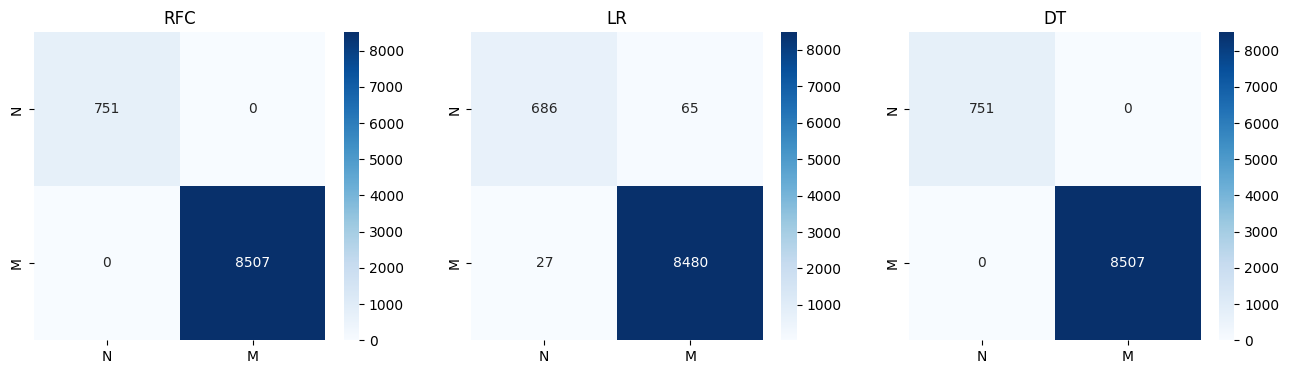

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
titles = ['RFC','LR', 'DT']
cms = [rfc_conf_matrix, lr_conf_matrix, dt_conf_matrix]
for i, ax in enumerate(axes.flat):
    sns.heatmap(pd.DataFrame(cms[i], index=['N', 'M'], columns=['N', 'M']), annot=True, cmap='Blues', ax=ax, fmt='g')
    ax.set(title=titles[i])

#### 3.3- Entrenamiento de los modelos WFS (With feature selection)

In [21]:
# Creamos el imputador para imputar los valores faltantes con la tecnica de la media
imp1 = SimpleImputer(strategy='mean')
# Entrenar el modelo RFC
rfc_mode1 = RandomForestClassifier(n_estimators=10, random_state=42)
pipelineRFC1 = make_pipeline(imp1, rfc_mode1)
pipelineRFC1.fit(X_train2, y_train2)
rfc_preds1 = pipelineRFC1.predict(X_test2)
rfc_conf_matrix1 = confusion_matrix(y_test2, rfc_preds1)

# Entrenar el modelo de regresión logística
lr_model1 = LogisticRegression(random_state=42, max_iter=1000)
pipelineLR1 = make_pipeline(imp1, lr_model1)
pipelineLR1.fit(X_train2, y_train2)
lr_preds1 = pipelineLR1.predict(X_test2)
lr_conf_matrix1 = confusion_matrix(y_test2, lr_preds1)

# Entrenar el modelo de árbol de decisión
dt_model1 = DecisionTreeClassifier(random_state=42)
pipelineDT1 = make_pipeline(imp, dt_model1)
pipelineDT1.fit(X_train2, y_train2)
dt_preds1 = pipelineDT1.predict(X_test2)
dt_conf_matrix1 = confusion_matrix(y_test2, dt_preds1)

print(y_test2.value_counts())

Malicious    8507
Benign        751
Name: label, dtype: Int64


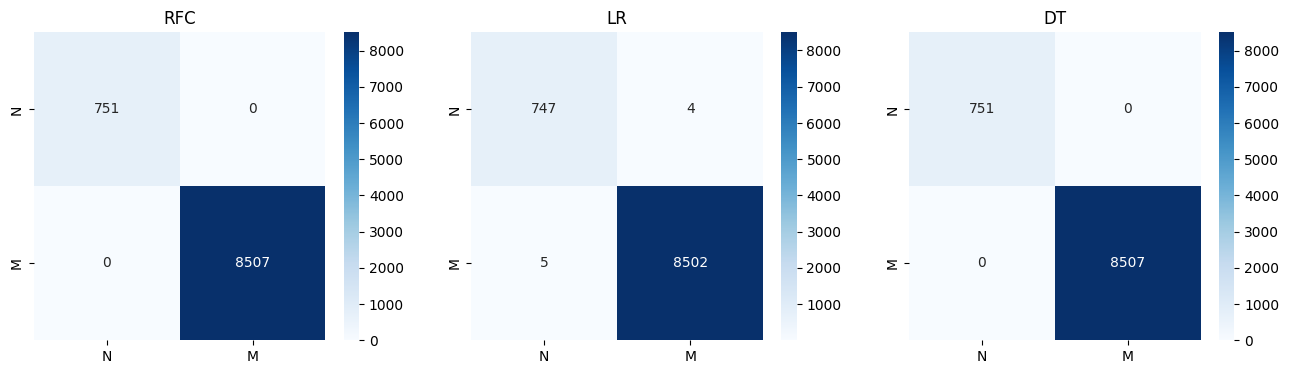

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
titles = ['RFC','LR', 'DT']
cms = [rfc_conf_matrix1, lr_conf_matrix1, dt_conf_matrix1]
for i, ax in enumerate(axes.flat):
    sns.heatmap(pd.DataFrame(cms[i], index=['N', 'M'], columns=['N', 'M']), annot=True, cmap='Blues', ax=ax, fmt='g')
    ax.set(title=titles[i])

#### 3.4- Metricas

<class 'dict'>


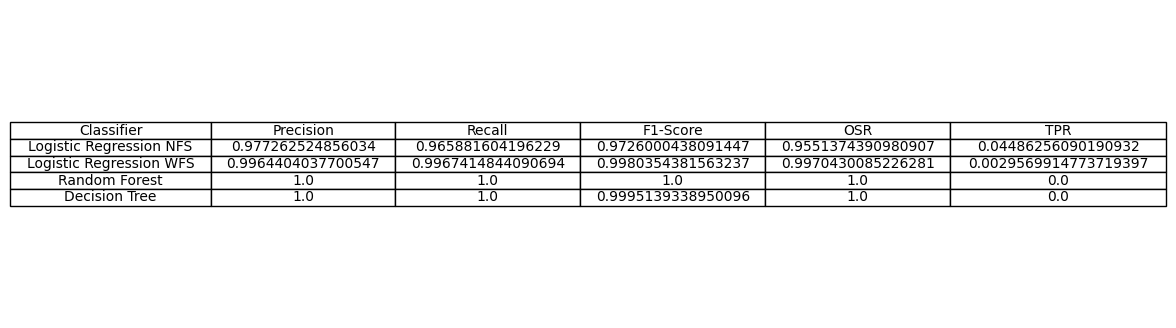

In [28]:
# Métricas para el modelo de regresión logística (lr) NFS
lr_report_nfs = classification_report(y_test1, lr_preds, output_dict=True)
lr_osr = (accuracy_score(y_test1, lr_preds) + lr_report_nfs['macro avg']['recall']) / 2
lr_tpr = lr_report_nfs['macro avg']['recall']
lr_fpr = 1 - lr_report_nfs['macro avg']['recall']

# Métricas para el modelo de regresión logística (lr) WFS
lr_report_wfs = classification_report(y_test2, lr_preds1, output_dict=True)
lr_osr1 = (accuracy_score(y_test2, lr_preds1) + lr_report_wfs['macro avg']['recall']) / 2
lr_tpr1 = lr_report_wfs['macro avg']['recall'] 
lr_fpr1 = 1 - lr_report_wfs['macro avg']['recall'] 

# Métricas para el modelo de árbol de decisión (dt)
dt_report = classification_report(y_test2, dt_preds1, output_dict=True)
dt_osr = (accuracy_score(y_test2, lr_preds1) + dt_report['macro avg']['recall']) / 2
dt_tpr = dt_report['macro avg']['recall']
dt_fpr = 1 - dt_report['macro avg']['recall']

# Métricas para el modelo de bosques aleatorios (rfc)
rfc_report = classification_report(y_test2, rfc_preds1, output_dict=True)
rf_osr = (accuracy_score(y_test2, rfc_preds1) + rfc_report['macro avg']['recall']) / 2
rf_tpr = rfc_report['macro avg']['recall']
rf_fpr = 1 - rfc_report['macro avg']['recall']

data = [
    {'Classifier': 'Logistic Regression NFS', 'Precision': lr_report_nfs['macro avg']['precision'], 'F1-Score': lr_report_nfs['macro avg']['f1-score'], 'OSR': lr_osr, 'TPR': lr_tpr, 'FPR': lr_fpr},
    {'Classifier': 'Logistic Regression WFS', 'Precision': lr_report_wfs['macro avg']['precision'], 'F1-Score': lr_report_wfs['macro avg']['f1-score'], 'OSR': lr_osr1, 'TPR': lr_tpr1, 'FPR': lr_fpr1},
    {'Classifier': 'Random Forest', 'Precision': rfc_report['macro avg']['precision'], 'F1-Score': rfc_report['macro avg']['f1-score'], 'OSR': rf_osr, 'TPR': rf_tpr, 'FPR': rf_fpr},
    {'Classifier': 'Decision Tree', 'Precision': dt_report['macro avg']['precision'], 'F1-Score': dt_report['macro avg']['f1-score'], 'OSR': dt_osr, 'TPR': dt_tpr, 'FPR': dt_fpr},
]

columns = ['Classifier', 'Precision', 'Recall', 'F1-Score', 'OSR', 'TPR', 'FPR']

fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('off')

table = ax.table(cellText=[list(d.values()) for d in data], colLabels=columns, loc='center', cellLoc='center', fontsize=14)
table.auto_set_column_width(col=list(range(len(columns))))

plt.show()